# Results of model-informed precision dosing using PKPD modelling

In [1]:
import os
import string

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
sns.set_theme()

from model import (
    define_hamberg_model,
    HambergEliminationRateCovariateModel
)

## Calibration to trial phase I data

Import data

In [25]:
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_I.csv')

# Define model
mechanistic_model, _ = define_hamberg_model(pk_only=True)
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_I.nc')

Reshape data and compute residuals

In [42]:
# Reshape data
temp = data[data.Observable == 'central_warfarin.warfarin_concentration']
ids = temp.ID.dropna().unique()
times = temp.Time.dropna().unique()
concs = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    concs[idx] = temp[temp.ID == _id].Value.values

covariates = np.empty(shape=(len(ids), 2))
# covariates[:, 0] = data[data.Observable == 'CYP2C9'].Value.values
# covariates[:, 1] = data[data.Observable == 'Age'].Value.values
covariates[:, 1] = data[data.Observable == 'CYP2C9'].Value.values
covariates[:, 0] = data[data.Observable == 'Age'].Value.values

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 2))
for idx in range(n_samples):
    parameters[idx] = population_model.compute_individual_parameters(
        parameters=pop_parameters[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates)

mechanistic_model.set_dosing_regimen(dose=10, start=0)
fits = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(parameters):
    for idd, indiv_params in enumerate(samples):
        fits[idx, idd] = mechanistic_model.simulate(indiv_params, times)[0]

Visualise results

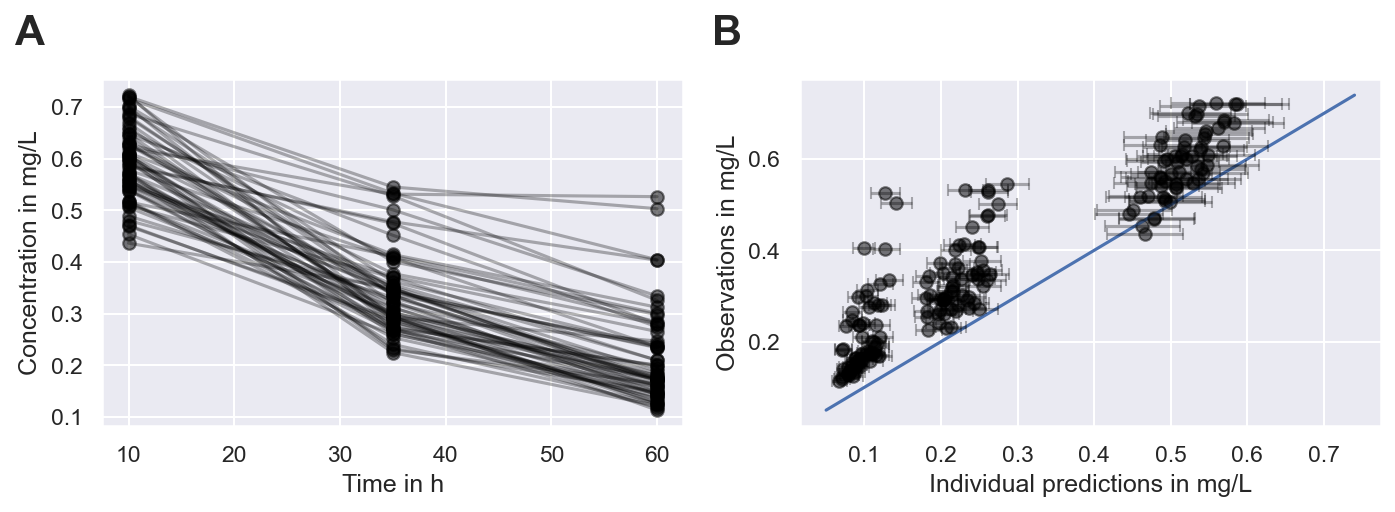

In [59]:
# Create layout
fontsize = 14
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.2)

# Create axes for measurements
axes = []
axes.append(plt.Subplot(fig, outer[0]))

# Create axis for residuals
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Label subplot groups
axes[0].text(
    -0.15, 1.1, string.ascii_uppercase[0], transform=axes[0].transAxes,
    size=20, weight='bold')
axes[1].text(
    -0.15, 1.1, string.ascii_uppercase[1], transform=axes[1].transAxes,
    size=20, weight='bold')

# Visualise measurements
for c in concs:
    axes[0].plot(
        times, c, marker='o', color='black',
        alpha=0.3)
    axes[0].scatter(
        times, c, marker='o', color='black',
        alpha=0.3)

# Visualise residuals
axes[1].plot([0.05, 0.74], [0.05, 0.74], color=sns.color_palette()[0])
medians = np.median(fits, axis=0)
fifth = medians - np.percentile(fits, axis=0, q=5)
ninetyfifth = np.percentile(fits, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[1].errorbar(
        f, concs[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3)
    axes[1].scatter(
        f, concs[idf], marker='o', color='black', alpha=0.3)

# Label axes
axes[0].set_xlabel('Time in h')
axes[0].set_ylabel('Concentration in mg/L')
axes[1].set_xlabel('Individual predictions in mg/L')
axes[1].set_ylabel('Observations in mg/L')


plt.show()